# Mini Web App Finding Similar Members with the Meetup API
This notebook will present a little application that uses the Meetup.com API to get member info from the Houston Data Science Meetup group.


## Get your API Key
To make this tutorial work, you will need to get an [API key from Meetup][1]. Once you get your key, place it in the api_key.txt file. Do not write any other contents to the fil.

## Reading the API Key into a variable
We open the file and read the key into a variable as a string

[1]: https://secure.meetup.com/meetup_api/key/

In [1]:
with open('api_key.txt') as f:
    key = f.read()

# Using the API
The [Meetup API][1] is quite extensive and has many endpoints to access much of the site's data.

### Get all members of Houston Data Science

We will use the **profiles** endpoint to first access information on each member. The URL name is **Houston-Data-Science**.

### Must loop to get all data
Meetup limits the maximum number of records returned to 200. We write a loop to continually call the API until all the of the records are returned.

### Use `requests` library
The popular `requests` library is used to make our web request. The response is JSON data which is converted to a Python list of dictionaries.

# NOT NECESSARY to do any API calls
The data from the API calls has been stored as a CSV file, so it's not necessary to actually make the following API calls. The second will take an extremely long time to complete.

[1]: https://secure.meetup.com/meetup_api
[2]: https://secure.meetup.com/meetup_api/console/?path=/:urlname/members

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
# IGNORE to avoid API Call
members = []
offset = 0
while True:
    url = f"https://api.meetup.com/Houston-Data-Science/members?key={key}&offset={offset}"
    req = requests.get(url)
    cur_list = req.json()
    members.extend(cur_list)
    if len(cur_list) < 200:
        break
    offset += 1

In [188]:
offset

17

In [189]:
len(members)

3483

In [190]:
# Houston Data Science ID
hds_id = 20021425

### Iterate through each member
We iterate through each member and extract the member ID, name, and URL of their member photo into a dictionary. We then convert this into a Pandas DataFrame.

In [381]:
d = {'id': [], 'name': [], 'photo_url': []}
for member in members:
    d['id'].append(member['id'])
    d['name'].append(member['name'])
    if 'photo' in member:
        pho = member['photo']
        if 'highres_link' in pho:
            d['photo_url'].append(pho['highres_link'])
        else:
            d['photo_url'].append(pho.get('photo_link', ''))
    else:
        d['photo_url'].append('')
member_info = pd.DataFrame(d).drop_duplicates()
member_info.to_csv('../data/member_info.csv', index=False)

## Read in data from CSV to save time

In [3]:
member_info = pd.read_csv('../data/member_info.csv')
member_info.head()

,id,name,photo_url
0,5402289,Honain,NaN
1,16691721,Ted Petrou,https://secure.meetupstatic.com/photos/member/...
2,46420262,Roy,https://secure.meetupstatic.com/photos/member/...
3,230046555,Gerardo Garcia,https://secure.meetupstatic.com/photos/member/...
4,186076150,Adam,https://secure.meetupstatic.com/photos/member/...


In [4]:
member_info.shape

(3324, 3)

## Collect Groups from each member
The first API call returned the ID for each member. We now use the **profiles** end point to get member data. The following call takes over an hour as it is rate limited.

In [2]:
import time
from collections import OrderedDict

In [297]:
mem_groups = OrderedDict()
for i, mem_id in enumerate(member_info['id'].values):
    if i % 300 == 0:
        print(i)
    time.sleep(.3)
    url = f'https://api.meetup.com/2/profiles/?member_id={mem_id}&key={key}'
    req = requests.get(url)
    if req.ok:
        try:
            data = req.json()
        except:
            continue
        if 'results' in data:
            groups = data['results']
            mem_groups[mem_id] = []
            for group in groups:
                mem_groups[mem_id].append(group['group']['name'])

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300


In [383]:
group_map = OrderedDict()
for mid, groups in mem_groups.items():
    for group in groups:
        if group not in group_map:
            group_map[group] = len(group_map)

In [384]:
r = len(mem_groups)
c = len(group_map)
arr = np.zeros((r, c))
arr.shape

(3324, 6061)

In [386]:
for i, (mid, groups) in enumerate(mem_groups.items()):
    for group in groups:
        arr[i, group_map[group]] = 1

In [387]:
member_group_count = pd.DataFrame(data=arr, index=mem_groups.keys(), columns=group_map.keys())
member_group_count.head()

,Austin Data Science,Houston Data Science,Data Science Toronto,Data for Good - Toronto,Machine Learning TO Meetup,Toronto Data Literacy Group,Quantum Computing and Data Science,Toronto Data Sciences,PyData Toronto,Sketch City,...,TaMeri Gun Club,North Texas ISSA,Korean Language and Culture Exchange in Midtown NYC,Korean As A Second Language,Austin Cloud Foundry PaaS Meetup,Cloud Foundry Meetup - San Francisco / Bay Area,PMI Silicon Valley Chapter,SD Startup Accelerator,"The UNetwork: For Speakers, Leaders & Influencers",SD Startups and Entrepreneurs
5402289,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16691721,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46420262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230046555,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186076150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [388]:
member_group_count.shape

(3324, 6061)

In [389]:
filt_row = member_group_count.sum(axis='columns') > 5
filt_col = member_group_count.sum() > 100
mem_group_final = member_group_count.loc[filt_row, filt_col]
mem_group_final.shape

(2029, 89)

In [390]:
mem_group_final.to_csv('../data/member_groups.csv')

# Read in the group data here from CSV

In [5]:
mem_group_final = pd.read_csv('../data/member_groups.csv', index_col=0)
mem_group_final.head()

,Houston Data Science,Sketch City,Houston Machine Learning,Houston Data Visualization Meetup,Houston R Users Group,Houston Energy Data Science Meetup,PyHou - Houston Python Enthusiasts!,Houston Bitcoin Meetup,The Houston Amazon Web Services (AWS) Group,Artificial Intelligence and Machine Learning for Robotics,...,Houston Social Youngsters- 20's and 30's,Houston Outdoor and International Adventure Club,Houston 20s & 30s Fun Stuff,Houston Legal Hackers,Houston Startup Founder 101,Houston Makes,Houston Arts + Culture,Software Future,Archway Gallery Featured Events,Spiritual Conversations and Exploration
16691721,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230046555,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186076150,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158982152,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230610339,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


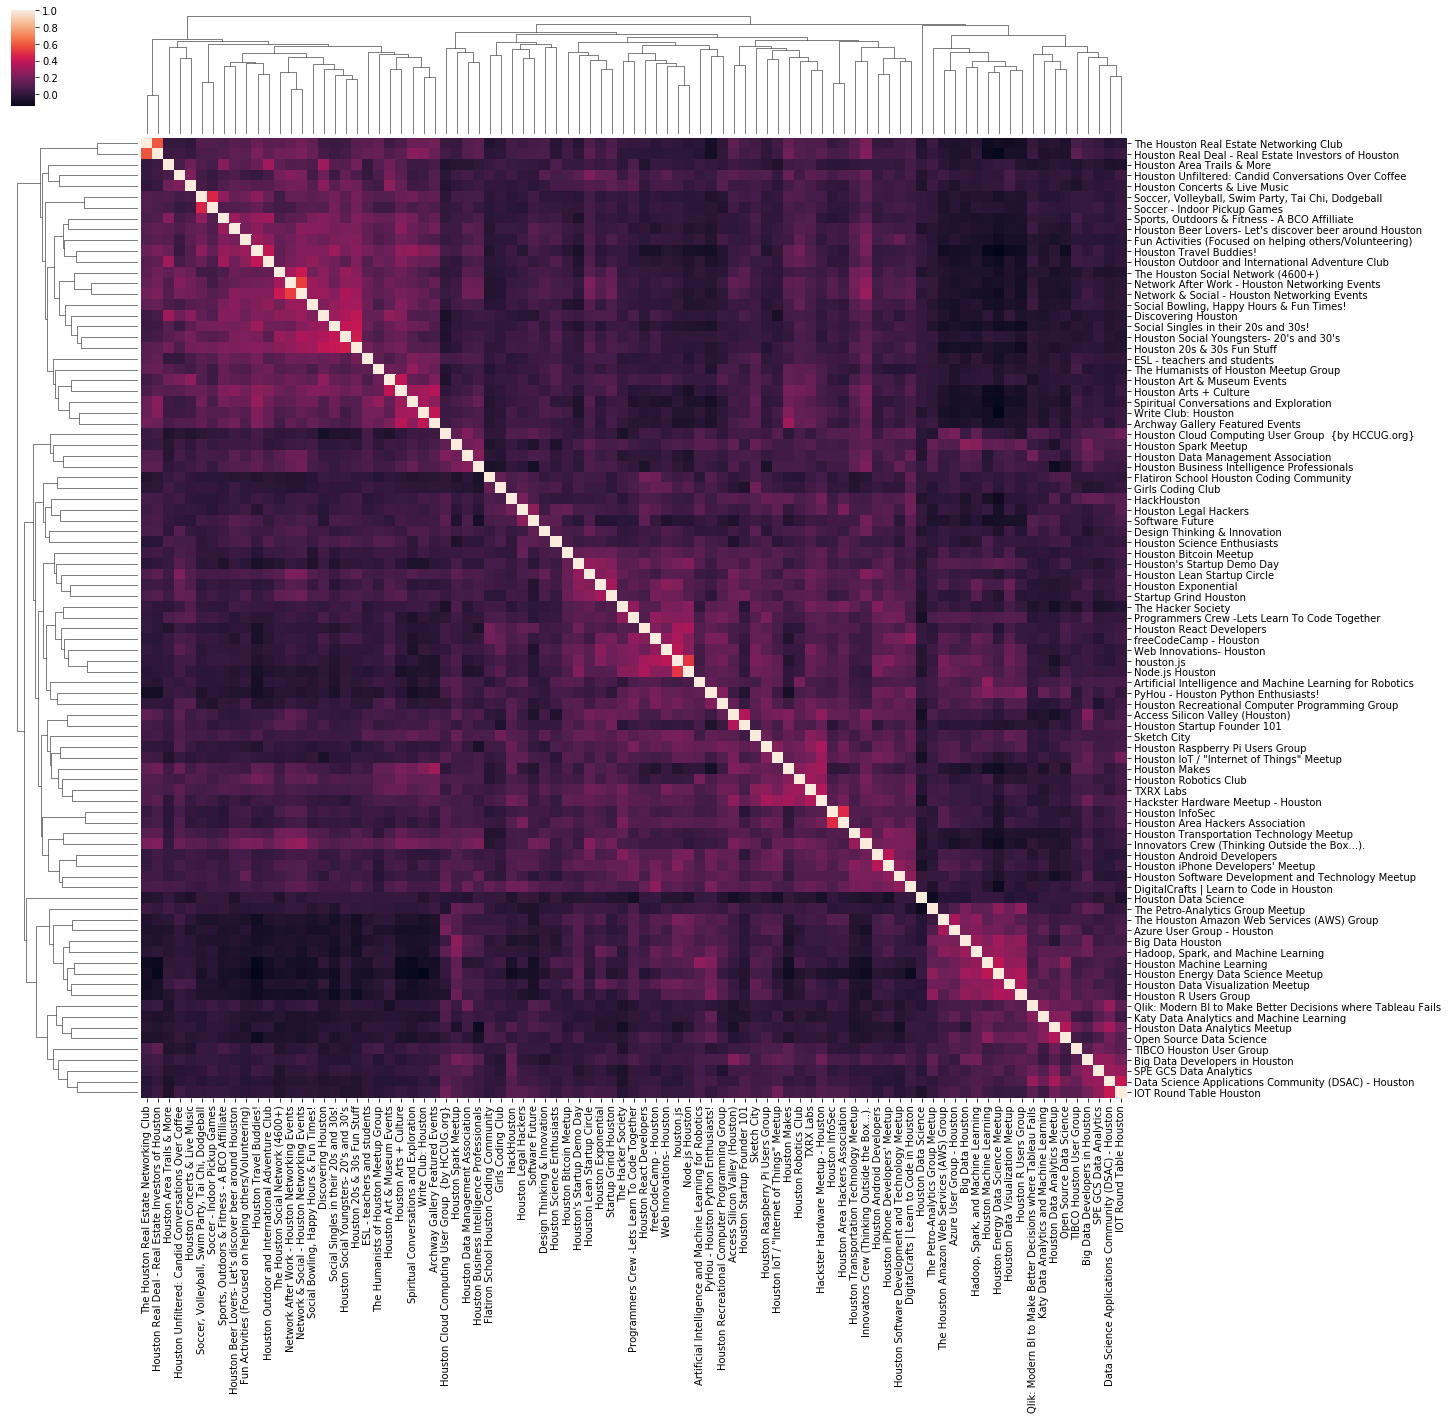

In [6]:
corr = mem_group_final.corr()
sns.clustermap(corr, figsize=(20, 20))

## Clustermap
A **`clustermap`** creates a heat map and performs hierarchical clustering at the same time. It will rearrange the column order so that the closest clusters of columns will appear together. The clustering is visualized with a dendogram outside of both the x and y axes. 

In [7]:
# find similar members
corr_mem = mem_group_final.T.corr()

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, Image
import ipywidgets as widgets

In [81]:
def get_similar(name):
    filt = member_info['name'] == name
    df = member_info[filt]
    if len(df) == 1:
        photo_url = df['photo_url'].values[0]
        mem_id = df['id'].values[0]
        if photo_url != '':
            if not isinstance(photo_url, float):
                display(Image(url=photo_url, width=400))
        else:
            display(f"{name} does not have an uploaded image")
        
        if mem_id in corr_mem.columns:
            scores = corr_mem[mem_id].sort_values(ascending=False).iloc[1:6]

            for id_, score in scores.items():
                filt2 = member_info['id'] == id_
                sim_df = member_info[filt2]

                sim_name = sim_df['name'].values[0]
                sim_photo_url = sim_df['photo_url'].values[0]
                display(f'{sim_name} has similarity score {round(score, 2)}')
                if not isinstance(sim_photo_url, float):
                    display(Image(url=sim_photo_url, width=100))
        else:
            display(f'{name} has not joined enough Meetup groups to find similar members')
    elif len(df) > 1:
        display("Not a unique name :(")
    return None

In [82]:
corr_mem.head()

,16691721,230046555,186076150,158982152,230610339,12914537,11612942,193619011,7614012,1752468,...,200887420,88630982,79871182,200403057,184011587,3439188,206539435,61673462,13754327,204175629
16691721,1.000000,0.420835,0.339544,0.270741,0.534843,0.138081,0.397562,0.339544,0.342692,0.442747,...,0.040444,0.254371,0.587299,0.200040,0.138081,0.178886,0.040444,0.176703,0.364852,0.534843
230046555,0.420835,1.000000,0.374254,0.443649,0.420835,0.157964,0.171340,0.374254,0.177322,0.309952,...,0.058450,0.285141,0.285141,0.228845,0.157964,0.355712,0.207081,0.198077,0.396481,0.420835
186076150,0.339544,0.374254,1.000000,0.083316,0.339544,0.214706,0.083316,0.738235,0.143070,0.210756,...,0.107120,0.590544,0.590544,0.311047,0.214706,0.287000,0.107120,0.259981,0.491403,0.339544
158982152,0.270741,0.443649,0.083316,1.000000,0.143920,0.412878,0.481352,0.083316,0.370358,0.346279,...,0.100512,0.035186,0.035186,0.240061,0.083316,-0.012723,0.213747,0.119024,0.283864,0.143920
230610339,0.534843,0.420835,0.339544,0.143920,1.000000,0.138081,0.143920,0.339544,0.142695,0.351954,...,0.040444,0.420835,0.420835,0.200040,0.138081,0.317328,0.040444,0.176703,0.364852,0.224739


In [83]:
corr_mem.shape

(2029, 2029)

In [131]:
vc = member_info['name'].value_counts()
uniq_mem = vc[vc == 1].index
idx1 = set(member_info.loc[member_info['name'].isin(uniq_mem), 'id'])

In [134]:
idx2 = set(corr_mem.index)

In [137]:
idx_final = list(idx1 & idx2)

In [147]:
filt = member_info['id'].isin(idx_final)
names = member_info.loc[filt, 'name'].sort_values().tolist()

In [148]:
w = widgets.Dropdown(options=names, description='Name', value=None)
interact(get_similar, name=w);

interactive(children=(Dropdown(description='Name', options=('#E', '220', '9589smithry', 'A', 'A.C. Van Dyke ',…